![](../img/330-banner.png)

Lecture 20: Survival analysis 
-------------------

UBC 2022-23 W2

Instructor: Amir Abdi

Office Hours: Mondays 5-6 PM

Anonymous Feedback: https://forms.gle/t21FhAVG8aY2mFs56

## Legends

    
| <img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/This_is_the_photo_of_Arthur_Samuel.jpg" width="100"> | <img src="https://www.ml.cmu.edu/images/news/mitchell-2017-wef-900-min.jpg" width="100">  | <img src="https://upload.wikimedia.org/wikipedia/commons/4/49/John_McCarthy_Stanford.jpg" width="100"> | <img src="https://datascience.columbia.edu/wp-content/uploads/2020/08/Vapnik_web.png" width="100"> | <img src="https://upload.wikimedia.org/wikipedia/commons/a/a1/Alan_Turing_Aged_16.jpg" width="100"> | <img src="https://upload.wikimedia.org/wikipedia/commons/1/1e/Yoshua_Bengio_2019_cropped.jpg" width="100"> |
| :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | 
| Arthur Samuel       | Tom Mitchell       |John McCarthy|  Vladimir N. Vapnik | Alan Turing | Yoshua Bengio |
| (1901-1990)    | 1951 - Now       |  1927 – 2011 | 1936 - Now | 1912 – 1954 | 1964-Now |
| First computer learning program | 1997 ML Texbook, CMU Prof | Co-coined term AI, Lisp,<br> Time-sharing, Garbage collection | SVM | Turing Test, Turning Machine | Turing Award<br> Father of Deep Learning


| <img src="https://upload.wikimedia.org/wikipedia/commons/d/d2/Lloyd_Shapley_2_2012.jpg" width="100"> | <img src="https://stat.columbia.edu/wp-content/uploads/connections-images/david-blei/Blei-David-1.jpg" width="100"> | <img src="http://t2.gstatic.com/licensed-image?q=tbn:ANd9GcTOOIquVIk-AUTan-9Rf0sG-Gl9P7ngVNdC2oLFUFc-4gkiB1wydkt2s36vjC8c7C8Xhtj6cxHNHEPR9xw" width="100"> | <img src="https://yale2020.yale.edu/sites/default/files/jordan_front_facing_bettman_1562_1_0_0_0.jpg" width="100"> | <img src="https://upload.wikimedia.org/wikipedia/commons/2/22/Yann_LeCun_-_2018_%28cropped%29.jpg" width="100"> |
|   :-----------:  | :-----------:  | :-----------:  | :-----------:  | :-----------: | 
| Lloyd Shapley | David Blei | Andrew Ng | Michael Jordan | Yann LeCun |
| 1923-2016  | ? - Now | 1976 - Now | 1956 - Now | ??? - Now | 
| Shapley values (SHAP) | LDA |  LDA, Coursera Founder, Director of SAIL | LDA | MetaAI Director, Turing Awardee, **CNN** |



## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

plt.rcParams["font.size"] = 12

# does lifelines try to mess with this?
pd.options.display.max_rows = 10

In [2]:
# new package we will learn today
import lifelines

### Announcements
- HW8 (**the very last homework!**) due April 12, 11:59pm

## Learning objectives

- Explain what is **censored** data. 
- Determine whether survival analysis is an appropriate tool for a given problem.
- Apply survival analysis in Python using the `lifelines` package.
- Interpret a **survival curve, such as the Kaplan-Meier curve**.
- Interpret the coefficients of a fitted **Cox proportional hazards model**.
- Make predictions for existing individuals and interpret these predictions.

## Customer churn: our standard approach

- Imagine that you are working for a subscription-based telecom company. 
- You want to come up with retention strategies for different customer segments. 
- So you want to model the "time to churn" to understand different factors affecting customer churn.   
- Suppose you are given this dataset [Customer Churn Dataset](https://www.kaggle.com/blastchar/telco-customer-churn), which is collected at a fixed time. 

In [3]:
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
train_df, test_df = train_test_split(df, random_state=123)
train_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6464,4726-DLWQN,Male,1,No,No,50,Yes,Yes,DSL,Yes,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),70.35,3454.6,No
5707,4537-DKTAL,Female,0,No,No,2,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,45.55,84.4,No
3442,0468-YRPXN,Male,0,No,No,29,Yes,No,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),98.80,2807.1,No
3932,1304-NECVQ,Female,1,No,No,2,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55,Yes
6124,7153-CHRBV,Female,0,Yes,Yes,57,Yes,No,DSL,Yes,...,Yes,Yes,No,No,One year,Yes,Mailed check,59.30,3274.35,No


- We are interested in predicting customer churn: the "Churn" column.  
  - **Customers who left within the last month**
  - **We are only looking at a snapshot of a system at a certain point in time**
- How will you approach this problem with the approaches we have seen so far? 
- How about treating this as a binary classification problem where we want to predict `Churn` (yes/no) from these -other columns.
- Before we look into survival analysis, let's just treat it as a binary classification model where we want to predict whether a customer churned or not. 

In [4]:
train_df.shape

(5282, 21)

In [5]:
train_df["Churn"].value_counts()

No     3912
Yes    1370
Name: Churn, dtype: int64

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6464 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5282 non-null   object 
 1   gender            5282 non-null   object 
 2   SeniorCitizen     5282 non-null   int64  
 3   Partner           5282 non-null   object 
 4   Dependents        5282 non-null   object 
 5   tenure            5282 non-null   int64  
 6   PhoneService      5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   InternetService   5282 non-null   object 
 9   OnlineSecurity    5282 non-null   object 
 10  OnlineBackup      5282 non-null   object 
 11  DeviceProtection  5282 non-null   object 
 12  TechSupport       5282 non-null   object 
 13  StreamingTV       5282 non-null   object 
 14  StreamingMovies   5282 non-null   object 
 15  Contract          5282 non-null   object 
 16  PaperlessBilling  5282 non-null   objec

Question: Does this mean there is no missing data?

Ok, let's try our usual approach:

In [7]:
train_df["SeniorCitizen"].value_counts()

0    4430
1     852
Name: SeniorCitizen, dtype: int64

In [8]:
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
drop_features = ["customerID"]
passthrough_features = ["SeniorCitizen"]
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

--------------

**[Study on your own]**

### Data Cleaning

In [9]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

In [10]:
# The following wouldn't work because there are some " " (whitespace) values in 'TotalCharges'
# preprocessor.fit(train_df);

Hmmm, one of the numeric features is causing problems?

Oh, looks like `TotalCharges` is not a numeric type. What if we change the type of this column to float? 

In [11]:
train_df["TotalCharges"]

6464     3454.6
5707       84.4
3442     2807.1
3932     149.55
6124    3274.35
         ...   
5218           
4060     3409.1
1346     1258.6
3454    1025.15
3582     232.35
Name: TotalCharges, Length: 5282, dtype: object

In [12]:
for val in train_df["TotalCharges"]:
    try:
        float(val)
    except ValueError:
        print(f'value "{val}" is not float')

value " " is not float
value " " is not float
value " " is not float
value " " is not float
value " " is not float
value " " is not float
value " " is not float
value " " is not float


Well, it turns out we can't see those problematic values because they are whitespace!

Let's replace the whitespaces with NaNs. 

In [13]:
train_df = train_df.assign(
    TotalCharges=train_df["TotalCharges"].replace(" ", np.nan).astype(float)
)
test_df = test_df.assign(
    TotalCharges=test_df["TotalCharges"].replace(" ", np.nan).astype(float)
)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6464 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5282 non-null   object 
 1   gender            5282 non-null   object 
 2   SeniorCitizen     5282 non-null   int64  
 3   Partner           5282 non-null   object 
 4   Dependents        5282 non-null   object 
 5   tenure            5282 non-null   int64  
 6   PhoneService      5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   InternetService   5282 non-null   object 
 9   OnlineSecurity    5282 non-null   object 
 10  OnlineBackup      5282 non-null   object 
 11  DeviceProtection  5282 non-null   object 
 12  TechSupport       5282 non-null   object 
 13  StreamingTV       5282 non-null   object 
 14  StreamingMovies   5282 non-null   object 
 15  Contract          5282 non-null   object 
 16  PaperlessBilling  5282 non-null   objec

But now we are going to have missing values and we need to include imputation for numeric features in our preprocessor. 

**[end of Study on your own]**

--------------

In [15]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features,
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

Now let's try that again...

In [16]:
preprocessor.fit(train_df);

It worked! Let's get the column names of the transformed data from the column transformer.

In [17]:
new_columns = (
    numeric_features
    + preprocessor.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + passthrough_features
)

In [18]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns=new_columns
)
X_test_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns=new_columns
)

In [19]:
X_train_enc.head()

,tenure,MonthlyCharges,TotalCharges,PaperlessBilling_No,PaperlessBilling_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineBackup_No,OnlineBackup_No internet service,...,StreamingMovies_No internet service,StreamingMovies_Yes,gender_Female,gender_Male,Partner_No,Partner_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,SeniorCitizen
6464,0.707712,0.185175,0.513678,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
5707,-1.248999,-0.641538,-0.979562,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3442,-0.148349,1.133562,0.226789,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3932,-1.248999,0.458524,-0.950696,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
6124,0.993065,-0.183179,0.433814,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [20]:
results = {}

In [21]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [22]:
X_train = train_df.drop(columns=["Churn"])
X_test = test_df.drop(columns=["Churn"])

y_train = train_df["Churn"]
y_test = test_df["Churn"]

### DummyClassifier

In [23]:
dc = DummyClassifier()

In [24]:
results["dummy"] = mean_std_cross_val_scores(
    dc, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.003 (+/- 0.000),0.001 (+/- 0.000),0.741 (+/- 0.000),0.741 (+/- 0.000)


Dummy model scores are pretty good because we have class imbalance. 

In [25]:
y_train.value_counts()

No     3912
Yes    1370
Name: Churn, dtype: int64

### LogisticRegression

In [26]:
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [27]:
results["logistic regression"] = mean_std_cross_val_scores(
    lr, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.003 (+/- 0.000),0.001 (+/- 0.000),0.741 (+/- 0.000),0.741 (+/- 0.000)
logistic regression,0.070 (+/- 0.005),0.011 (+/- 0.000),0.804 (+/- 0.013),0.809 (+/- 0.002)


In [28]:
confusion_matrix(y_train, cross_val_predict(lr, X_train, y_train))

array([[3516,  396],
       [ 637,  733]])

- Logistic regression beats the dummy model. 
- But it seems like we have many false negatives. 

### RandomForestClassifier

Let's try random forest model. 

In [29]:
rf = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=100))

In [30]:
results["random forest"] = mean_std_cross_val_scores(
    rf, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.003 (+/- 0.000),0.001 (+/- 0.000),0.741 (+/- 0.000),0.741 (+/- 0.000)
logistic regression,0.070 (+/- 0.005),0.011 (+/- 0.000),0.804 (+/- 0.013),0.809 (+/- 0.002)
random forest,0.376 (+/- 0.037),0.027 (+/- 0.002),0.788 (+/- 0.015),0.998 (+/- 0.000)


In [31]:
confusion_matrix(y_train, cross_val_predict(rf, X_train, y_train))

array([[3522,  390],
       [ 727,  643]])

- Random forest is not improving the scores. 

### Attention
- After trying out all the usual things **should we be happy with the scores?**
- Are we doing anything **fundamentally WRONG** when we treat this problem as a binary classification? 
<br><br><br><br><br><br><br>

The rest of the class is about what is **WRONG** with what we just did :-)

## Censoring and survival analysis

### Time to event and censoring

- When we treat the problem as a binary classification problem, we predict whether a customer would churn or not at a particular point in time, when the data was collected. 
- If a customer has not churned yet, wouldn't it be more useful to understand when they are likely to churn so that we can offer them promotions etc?  
- Here we are actually interested in the time till the event of churn occurs.  

**Survival Analysis is**: Analyze **the time until an event occurs**. For example,

- the time until a customer leaves a subscription service (this dataset)
- the time until a disease kills its host
- the time until a piece of equipment breaks
- the time that someone unemployed will take to land a new job
- the time until you wait for your turn to get a surgery

Although this branch of statistics is usually referred to as **Survival Analysis**, the event in question does not need to be related to actual "survival". 

We are interested in 
- **the time until something happens**,   
or 
- **whether or not something will happen in a certain time frame**.

In our dataset there is a column called "tenure", which encodes this temporal aspect of the data (**number of months the customer has stayed with the company**)

In [32]:
train_df[["tenure"]].head()

,tenure
6464,50
5707,2
3442,29
3932,2
6124,57


But we only have **tenure** till the point we collected the data. 

**Question:** But why is this different? Can't you just use the techniques you learned so far (e.g., regression models) to predict the time (tenure in our case)? 

Answer: Because, we don't have all the information. For customers who are already with us, we don't know what "tenure value" to include not to under-estimate their loyalty. 

If you could **observe the actual time** in all occurrences (but you usually cannot).   
Frequently, there will be some kind of **censoring** which will not allow you to observe the exact time that the event happened for all units/individuals that are being studied.

<br><br><br><br><br><br>

<br><br><br><br>
**censoring in survival analysis**: 
Censoring occurs when the event of interest is not observed for some subjects before the study is terminated.

**Right Censoring**: When a subject leaves the study before an event occurs, or the study ends before the event has occurred.

(there are other types of censoring)

<br><br><br><br>

In [33]:
train_df[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


- What this means is that we **don't have correct target values** to train or test our model.
- This is a problem!

Let's consider some approaches to deal with this **censoring** issue.

### Approach 1: Only consider the examples where "Churn"=Yes

Let's just consider the cases **_for which we have the actual time_**, to obtain the average subscription length.

In [34]:
train_df_churn = train_df.query(
    "Churn == 'Yes'"
)  # Consider only examples where the customers churned.
test_df_churn = test_df.query(
    "Churn == 'Yes'"
)  # Consider only examples where the customers churned.
train_df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3932,1304-NECVQ,Female,1,No,No,2,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55,Yes
301,8098-LLAZX,Female,1,No,No,4,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.45,396.10,Yes
5540,3803-KMQFW,Female,0,Yes,Yes,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.55,20.55,Yes
4084,2777-PHDEI,Female,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,No,Electronic check,78.05,78.05,Yes
3272,6772-KSATR,Male,0,No,No,1,Yes,Yes,Fiber optic,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,81.70,81.70,Yes


In [35]:
train_df.shape

(5282, 21)

In [36]:
train_df_churn.shape

(1370, 21)

In [37]:
numeric_features

['tenure', 'MonthlyCharges', 'TotalCharges']

In [38]:
preprocessing_notenure = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features[1:],  # Getting rid of the tenure column
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
)

In [39]:
tenure_lm = make_pipeline(preprocessing_notenure, Ridge())

tenure_lm.fit(train_df_churn.drop(columns=["tenure"]), train_df_churn["tenure"]);

Predict on **test** set:

In [40]:
y_test_tenure = tenure_lm.predict(test_df_churn.drop(columns=["tenure"]))
pd.DataFrame(
    y_test_tenure[:10],
    columns=["tenure_predictions"],
)

,tenure_predictions
0,5.062449
1,13.198645
2,11.859455
3,5.865562
4,58.154842
5,3.757932
6,18.932070
7,7.720893
8,36.818041
9,7.263541


In [41]:
print('average tenure:', y_test_tenure.mean())

average tenure: 18.413984362589243


`tenure_ml` model is trained on only **churned** samples.

What do you think about our `tenure_ml` model?
- Does it suffer from any biases?
- Is it underestimating the `tenure` or overestimating the `tenure` (given other features)?

<br><br><br><br><br>

**Answer:** On average they will be **underestimates** (too small), because we are ignoring the currently subscribed (un-churned) customers. Our dataset is a biased sample of those who churned within the time window of the data collection. Long-time subscribers were more likely to be removed from the dataset! This is a common mistake - see the [Calling Bullshit video](https://www.youtube.com/watch?v=ITWQ5psx9Sw) from the README!

<br><br>

### Approach 2: Assume everyone churns right now

Assume everyone churns right now - in other words, use the original dataset. 

In [42]:
train_df[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


In [43]:
tenure_lm.fit(train_df.drop(columns=["tenure"]), train_df["tenure"]);

In [44]:
y_test_tenure = tenure_lm.predict(test_df_churn.drop(columns=["tenure"]))
pd.DataFrame(
    y_test_tenure[:10],
    columns=["tenure_predictions"],
)

,tenure_predictions
0,6.400047
1,20.220392
2,22.332746
3,12.825470
4,59.885968
5,7.075453
6,17.731498
7,10.407862
8,38.425365
9,10.854500


In [45]:
print('average tenure:', y_test_tenure.mean())

average tenure: 19.086611636615828


This `tenure_ml` model is trained on all samples (churn and not-churn).

What do you think about our `tenure_ml` model?

- Does it suffer from any biases?
- Is it underestimating the tenure or overestimating the tenure (given other features)?

<br><br><br><br><br>

It will be an **underestimate** again. For those still subscribed, while we did not remove them, we recorded a total tenure shorter than in reality, because they will keep going for some amount of time. 

<br><br>

### Approach 3: Survival analysis

Deal with this properly using [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis).

**Survival Analysis: analyzing the expected duration of time until one event occurs**

- You may learn about this in a statistics course.
- We will use the `lifelines` package in Python and will not go into the math/stats of how it works.

In [46]:
train_df[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


#### Types of questions we might want to answer:

1. How long do customers stay with the service? 
2. For a particular customer, can we predict how long they might stay with the service?
3. What factors influence a customer's churn time?

## Break (5 min)

![](../img/eva-coffee.png)


## Kaplan-Meier survival curve

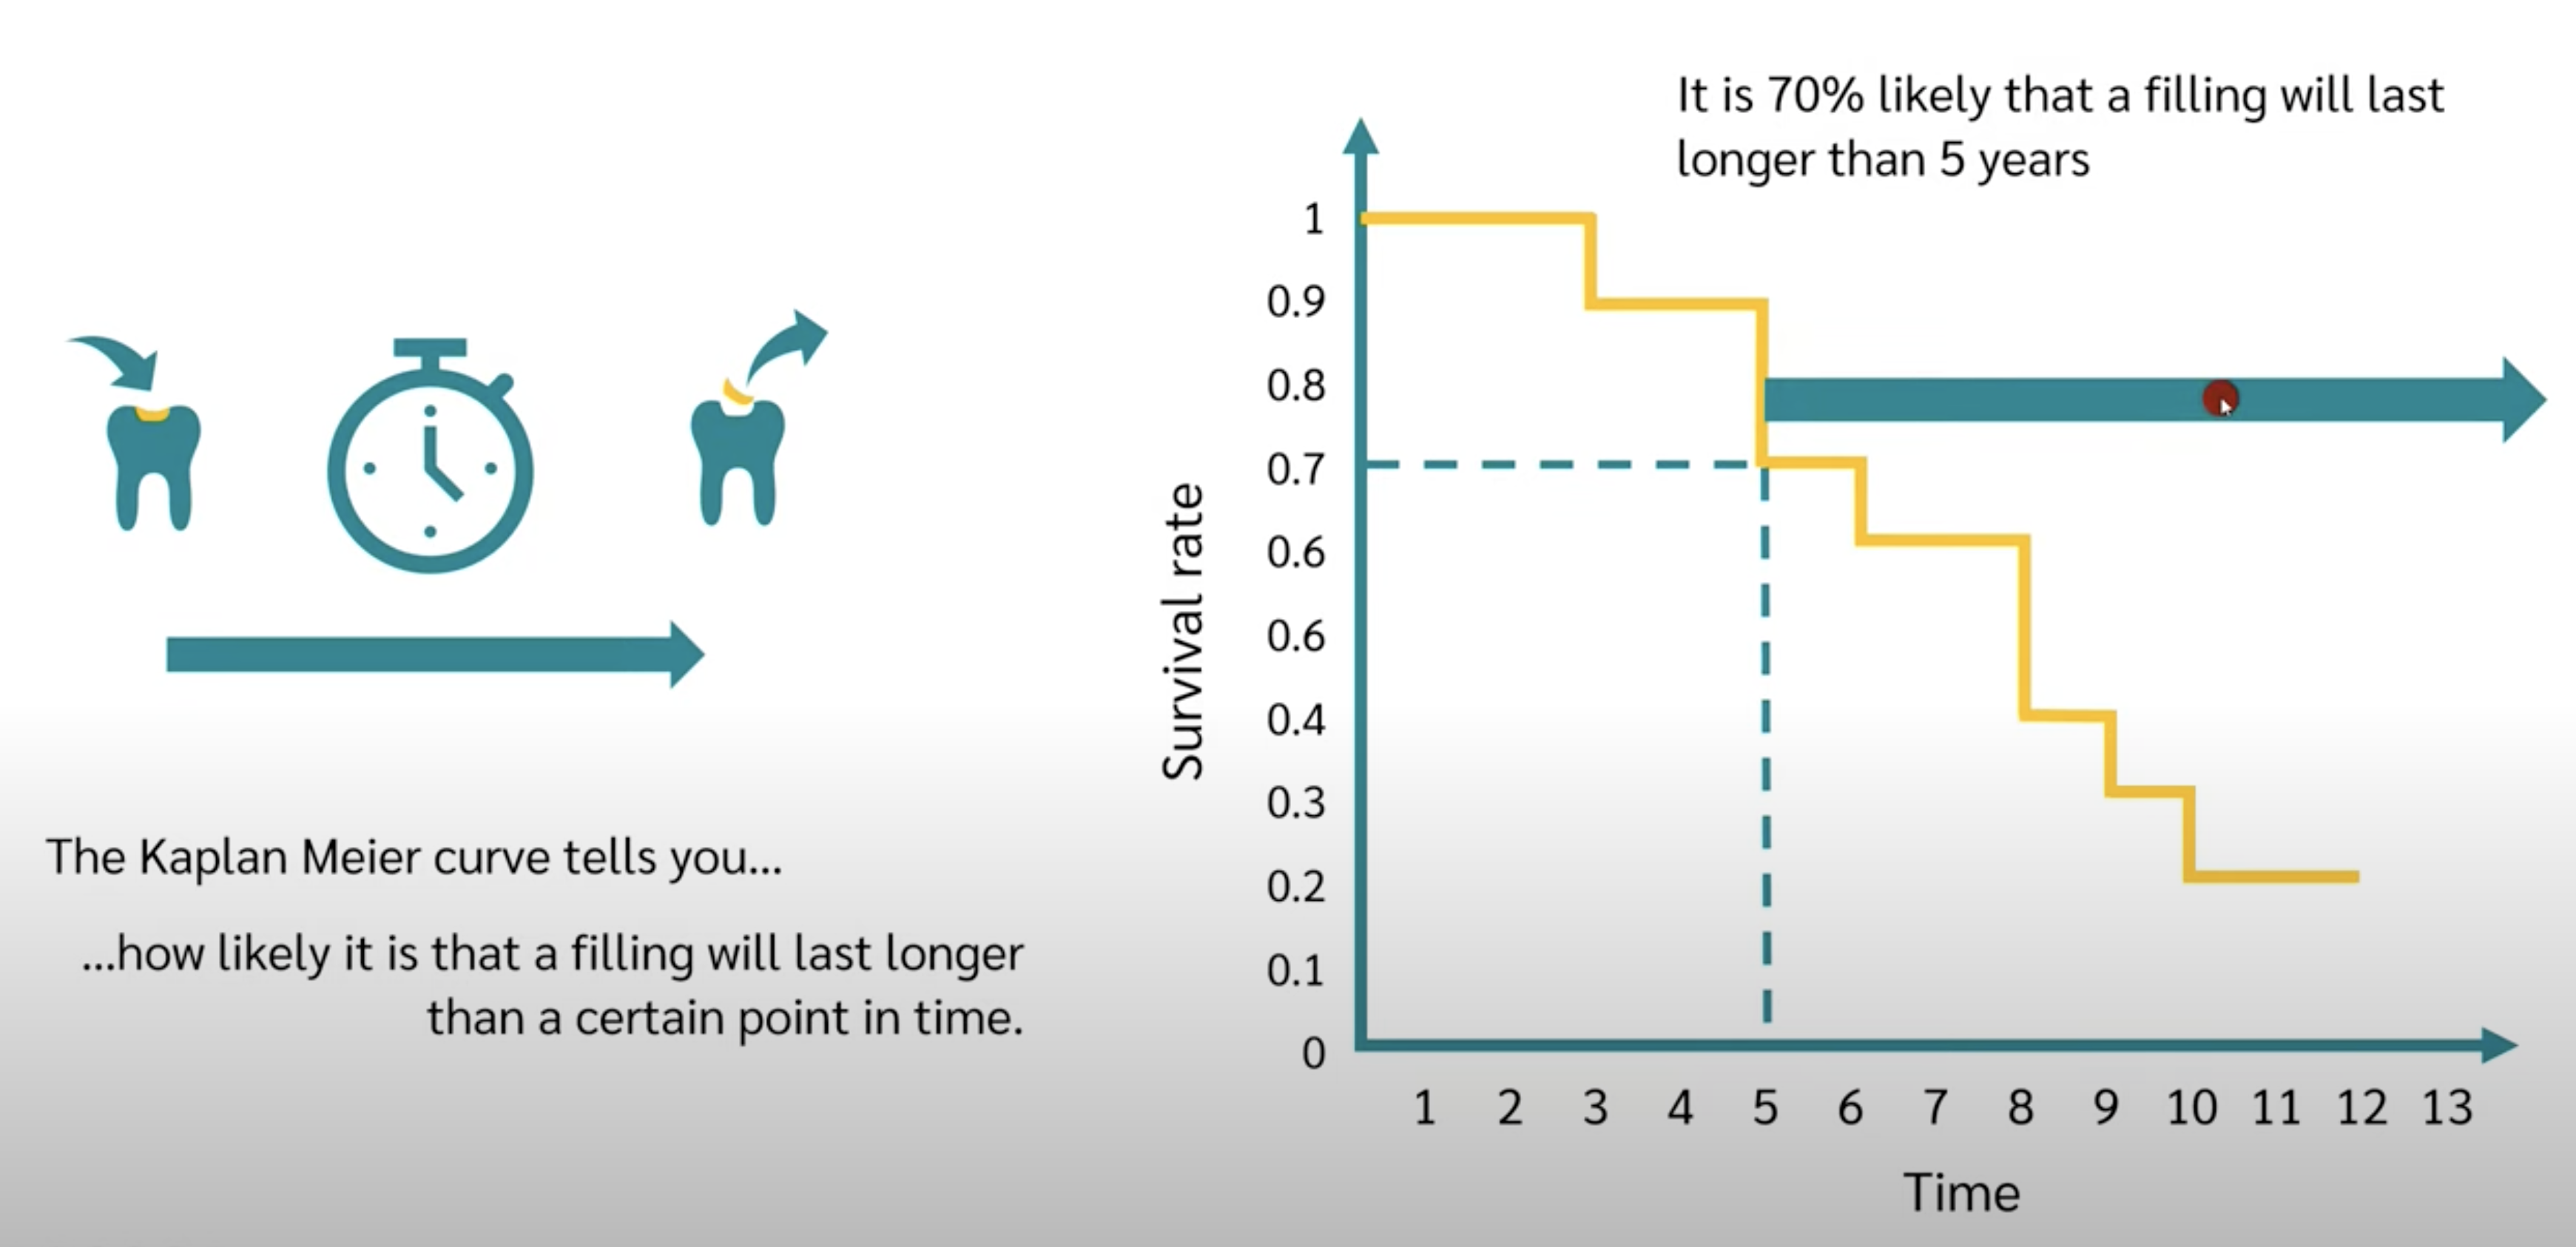

[img source](https://www.youtube.com/watch?v=L_ziqYhksG8)

Before we do anything further, I want to modify our dataset slightly:

1. I'm going to drop the `TotalCharges` (yes, after all that work fixing it) because it's a bit of a strange feature.
  - Its value actually changes over time, but we only have the value at the end.
  - We still have `MonthlyCharges`.
2. I'm going to not scale the `tenure` column, as **it will be more convenient for teaching purpises** to keep it in its original units of months. 

Just for our sanity, I'm redefining the features. 

In [47]:
numeric_features = ["MonthlyCharges"]
drop_features = ["customerID", "TotalCharges"]
passthrough_features = ["tenure", "SeniorCitizen"]  # don't want to scale tenure
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [48]:
preprocessing_final = make_column_transformer(
    (
        FunctionTransformer(lambda x: x == "Yes"),
        target_column,
    ),  # because we need it in this format for lifelines package
    ("passthrough", passthrough_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features),
    ("drop", drop_features),
)

In [49]:
preprocessing_final.fit(train_df);

Let's get the column names of the columns created by our column transformer. 

In [50]:
new_columns = (
    target_column
    + passthrough_features
    + numeric_features
    + preprocessing_final.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

In [51]:
train_df_surv = pd.DataFrame(
    preprocessing_final.transform(train_df), index=train_df.index, columns=new_columns
)
test_df_surv = pd.DataFrame(
    preprocessing_final.transform(test_df), index=test_df.index, columns=new_columns
)

In [52]:
train_df_surv.head()

,Churn,tenure,SeniorCitizen,MonthlyCharges,PaperlessBilling_No,PaperlessBilling_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineBackup_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,gender_Female,gender_Male,Partner_No,Partner_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No
6464,0.0,50.0,1.0,0.185175,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5707,0.0,2.0,0.0,-0.641538,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3442,0.0,29.0,0.0,1.133562,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3932,1.0,2.0,1.0,0.458524,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
6124,0.0,57.0,0.0,-0.183179,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


- We'll start with a model called `KaplanMeierFitter` from `lifelines` package to get a **Kaplan Meier curve**.  
- For this model we only use two columns: **tenure** and **churn**. 
  - We do not use any other features. 

In [53]:
import lifelines

In [54]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(
    durations=train_df_surv["tenure"], 
    event_observed=train_df_surv["Churn"]
);

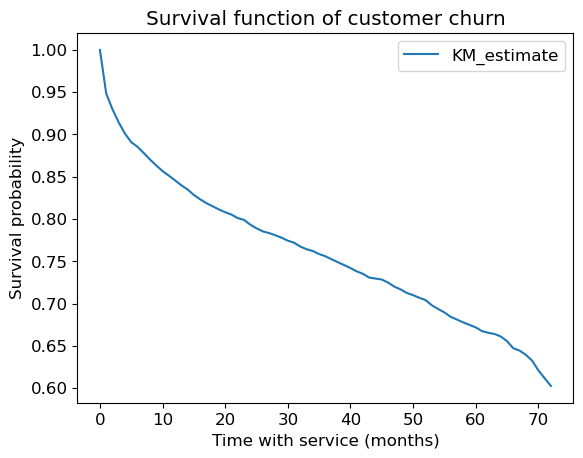

In [55]:
kmf.survival_function_.plot();
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

What is this plot telling us?
- It shows the **probability of survival over time**.
- For example, after 20 months the probability of survival is ~0.8. 
- Over time it's going down. 

**What's the average tenure?**

Which of the following 3 is a better estimate?

1. Average of all tenures

In [56]:
np.mean(train_df_surv["tenure"])

32.6391518364256

2. What's the average tenure of the people who churned

In [57]:
np.mean(train_df_surv.query("Churn == 1.0")["tenure"])

17.854744525547446

3. What's the average tenure of the people who did not churn

In [58]:
np.mean(train_df_surv.query("Churn == 0.0")["tenure"])

37.816717791411044

<br><br><br><br>
- Let's look at the histogram of number of people who **have not churned**. 
- The key point here is that people _joined at different times_. 

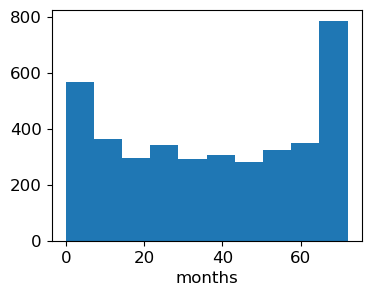

In [59]:
plt.figure(figsize=(4, 3))
train_df_surv[train_df_surv['Churn'] == 0]["tenure"].hist(grid=False)
plt.xlabel("months");

Since the data was collected at a fixed time and these are the people who hadn't yet churned, those with larger `tenure` values here must have joined earlier.

<br><br><br><br>
Now, let's get back to the **lifelong** library

In Kaplan-Meier survival analysis, 
- Mean survival: The mean survival time is estimated as the area under the survival curve in the interval 0 to $t_{max}$
- Median survival: The median survival is the smallest time at which the survival probability drops to 0.5 (50%) or below

Q: What is the Median Survival value in the above Kaplan-Meier curve?

A: We cannot say, the chart ends at 70 months. The median survival is probably somewhere around 80-90 months if we visually extrapolate into the future.

In [60]:
kmf.median_survival_time_

inf

`inf` in this library means: Cannot calculate!

In [61]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.948426
2.0,0.929756
3.0,0.914171
4.0,0.900966
...,...
68.0,0.639421
69.0,0.632618
70.0,0.621069


Lifelines can also give us some "error bars":

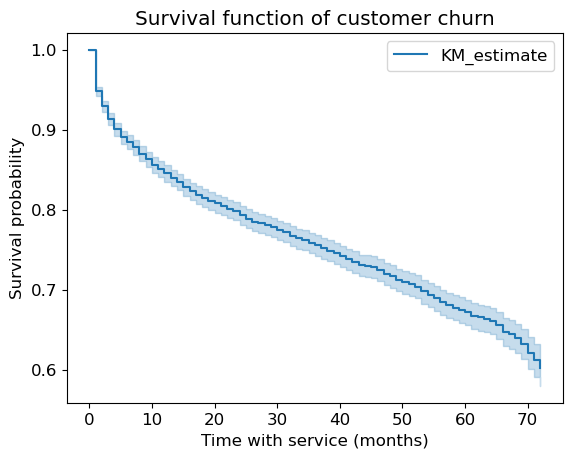

In [62]:
kmf.plot()
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- We already have some actionable information here.
- The **curve drops down fast at the beginning** suggesting that **people tend to leave early on**. 
  - If there would have been a big drop in the curve, it means a bunch of people left at that time (e.g., after a 1-month free trial). 
- BTW, the [original paper by Kaplan and Meier](https://web.stanford.edu/~lutian/coursepdf/KMpaper.pdf) has been cited over 62,000 times!

We can also create the K-M curve for different subgroups:

In [63]:
T = train_df_surv["tenure"]
E = train_df_surv["Churn"]
senior = train_df_surv["SeniorCitizen"] == 1

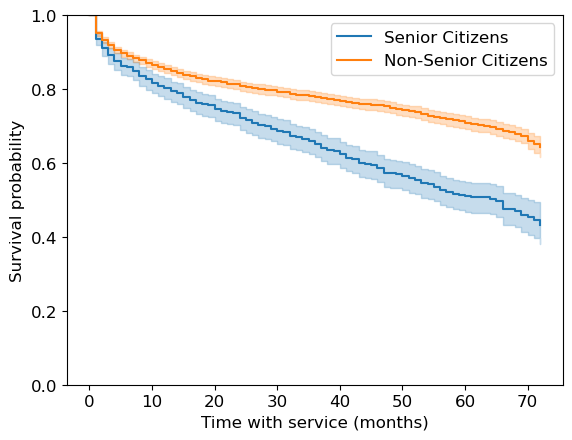

In [64]:
ax = plt.subplot(111)

kmf.fit(T[senior], event_observed=E[senior], label="Senior Citizens")
kmf.plot(ax=ax)

kmf.fit(T[~senior], event_observed=E[~senior], label="Non-Senior Citizens")
kmf.plot(ax=ax)

plt.ylim(0, 1)
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

**The chances of the senior citizen churning is higher**

- It looks like senior citizens churn more quickly than others.
- This is quite useful!

<br><br>

## Cox proportional hazards model

- We haven't been incorporating other features in the model so far. 
- The Cox proportional hazards model is a commonly used model that allows us to **interpret how features influence a censored tenure/duration**. 
- You can think of it like **feature importance for survival analysis**: 
  - we will get a coefficient for each feature that tells us how it influences survival.
- It makes some strong assumptions (**proportional hazards assumption**) that may not be true, but we won't go into this here.
- **The proportional hazard model works multiplicatively, like linear regression with log-transformed targets.** (What?!! Don't worry, you'll figure it out!)

---------
What is hazard?
- The probability that a subect who is under observation has an **event** at that time


**proportional hazards assumption**: 
- The hazards are proportional, i.e., the **relative hazard** remains **constant** over **time** (ratio of hazard to baseline hazard is constant)

Relative to what?
- Relative to the **baseline hazard**


What is **baseline hazard**?
- It corresponds to the value of the hazard if **all the features are equal to zero** (i.e., the intercept).

---------

Now, read the **proportional hazards assumption** one more time and see if it makes sense.

---------

In [65]:
cph = lifelines.CoxPHFitter()
# cph.fit(train_df_surv, duration_col="tenure", event_col="Churn");

-----------
(Optional)

**Collinearity**: linear dependence of columns (here: features) of the matrix
  - **Collinearity in simpler terms**: when some columns are linear combinations of the other columns  

To learn why **Collinearity** is a problem for matrix inversion, check this out: https://www.stat.cmu.edu/~larry/=stat401/lecture-17.pdf

------------------

- Going to [this URL](https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model), it seems the easiest solution is to add a penalizer.
  - We're adding **regularization**; `lifelines` adds both L1 and L2 regularization, aka elastic net)
  - This is similar to switching from `LinearRegression` to `Ridge Regression`.
- Adding `drop='first'` on our OHE might have helped with this.
    - Because it would have removed the two **Collinear columns** of the  OHE feature
      - Consider going back and test it yourself: `OneHotEncoder(handle_unknown="ignore", sparse=False, drop='first'), categorical_features)`


In [66]:
cph = lifelines.CoxPHFitter(penalizer=0.1)

# ------- Notice duration_col and event_col --------------
cph.fit(
    train_df_surv, 
    duration_col="tenure", 
    event_col="Churn"
);

We can look at the coefficients learned by the model and start interpreting them! 

In [67]:
cph_params = pd.DataFrame(cph.params_).sort_values(by="coef", ascending=False)
cph_params

,coef
covariate,
Contract_Month-to-month,0.812875
OnlineSecurity_No,0.311151
OnlineBackup_No,0.298561
PaymentMethod_Electronic check,0.280801
Partner_No,0.244814
...,...
OnlineBackup_Yes,-0.282600
PaymentMethod_Credit card (automatic),-0.302801
OnlineSecurity_Yes,-0.330346


- Looks like month-to-month leads to more churn, two-year contract leads to less churn; this makes sense!!!

In [68]:
cph.baseline_hazard_

,baseline hazard
0.0,0.000000
1.0,0.020883
2.0,0.009180
3.0,0.008321
4.0,0.007563
...,...
68.0,0.032779
69.0,0.050586
70.0,0.094493
71.0,0.083124


Reminder: **Proportional hazards assumption**
- The hazards are proportional, i.e., the **relative hazard remains constant over time**

*Statistics reminder*: covariate = feature = indepedent variable = [continuous] predictor

In [69]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
SeniorCitizen,-0.019556,0.980634,0.057254,-0.131773,0.092660,0.876540,1.097088,0.0,-0.341571,7.326741e-01,0.448757
MonthlyCharges,-0.003185,0.996820,0.040129,-0.081837,0.075467,0.921422,1.078387,0.0,-0.079377,9.367329e-01,0.094290
PaperlessBilling_No,-0.075063,0.927685,0.068817,-0.209943,0.059816,0.810631,1.061641,0.0,-1.090765,2.753764e-01,1.860523
PaperlessBilling_Yes,0.075063,1.077953,0.068817,-0.059816,0.209943,0.941938,1.233608,0.0,1.090765,2.753764e-01,1.860523
Contract_Month-to-month,0.812875,2.254380,0.069188,0.677268,0.948482,1.968493,2.581787,0.0,11.748725,7.169269e-32,103.459873
...,...,...,...,...,...,...,...,...,...,...,...
Partner_No,0.244814,1.277384,0.067499,0.112519,0.377109,1.119094,1.458063,0.0,3.626946,2.867927e-04,11.767704
Partner_Yes,-0.244814,0.782850,0.067499,-0.377109,-0.112519,0.685841,0.893580,0.0,-3.626946,2.867927e-04,11.767704
InternetService_DSL,-0.161001,0.851291,0.072286,-0.302679,-0.019324,0.738836,0.980862,0.0,-2.227289,2.592797e-02,5.269347


To learn the details of each column in the above DataFrame, check this: http://www.sthda.com/english/wiki/cox-proportional-hazards-model

---------
**Post-lecture update**:**  
Q: A student asked on why `SeniorCitizen` has a negative coef, while the KapanMeier model predicted faster churn for senior citizens?

Answer: These are two different models; one is `KapanMeier` which does not look at the features, and the other is CPH, which is a linear regression model trained on the data. You can't expect them to arrive at similar conclusions.

---------

-----------
**Note**: Cox Proportional-Hazard model is a regression model, but, it does not directly apply on the features; some transformation happen before the regression model is applied. To be more precise, Cox Proportional-Hazard model is a multiple linear regression of the logarithm of the hazard function of the features.

-----------

### What if we directly estimate 'Tenure' with a Regression model?



In [70]:
y_train.head()

6464     No
5707     No
3442     No
3932    Yes
6124     No
Name: Churn, dtype: object

Our target is **tenure**

In [71]:
X_train.drop(columns=["tenure"]).head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6464,4726-DLWQN,Male,1,No,No,Yes,Yes,DSL,Yes,Yes,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),70.35,3454.60
5707,4537-DKTAL,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45.55,84.40
3442,0468-YRPXN,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),98.80,2807.10
3932,1304-NECVQ,Female,1,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55
6124,7153-CHRBV,Female,0,Yes,Yes,Yes,No,DSL,Yes,No,Yes,Yes,No,No,One year,Yes,Mailed check,59.30,3274.35


I'm redefining feature types and our preprocessor for our sanity. 

In [72]:
numeric_features = ["MonthlyCharges"]
drop_features = ["customerID", "tenure", "TotalCharges"]
passthrough_features = ["SeniorCitizen"]
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [73]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features,
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

In [74]:
preprocessor.fit(X_train);

In [75]:
new_columns = (
    numeric_features
    + preprocessor.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + passthrough_features
)

In [76]:
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
lr.fit(X_train, y_train)
lr_coefs = pd.DataFrame(
    data=np.squeeze(lr[1].coef_), index=new_columns, columns=["Coefficient"]
)

In [77]:
lr_coefs.sort_values(by="Coefficient", ascending=False)

,Coefficient
Contract_Month-to-month,1.117063
InternetService_Fiber optic,0.522513
OnlineSecurity_No,0.349206
PaymentMethod_Electronic check,0.311261
OnlineBackup_No,0.253954
...,...
MonthlyCharges,-0.172977
OnlineSecurity_Yes,-0.242936
PaymentMethod_Credit card (automatic),-0.260652
InternetService_DSL,-0.416242


Compare the above coefficients with the Cox Prop. Hazard model coefficeints:

In [78]:
cph_params

,coef
covariate,
Contract_Month-to-month,0.812875
OnlineSecurity_No,0.311151
OnlineBackup_No,0.298561
PaymentMethod_Electronic check,0.280801
Partner_No,0.244814
...,...
OnlineBackup_Yes,-0.282600
PaymentMethod_Credit card (automatic),-0.302801
OnlineSecurity_Yes,-0.330346


Comparison:
- There is some agreement, which is good.
- The correlation (shown below) is very high

In [79]:
print(
    'Pearson Correlation between the coefficients of LogisticRegression and Cox Prop. Hazard:',
    np.corrcoef(
        lr_coefs.sort_index().Coefficient.values, 
        cph_params.sort_index().coef.values
    )[0,1]
)

Pearson Correlation between the coefficients of LogisticRegression and Cox Prop. Hazard: 0.8857302501318022


<br><br><br><br>
Another thing we get with `lifelines` is confidence intervals on the coefficients:

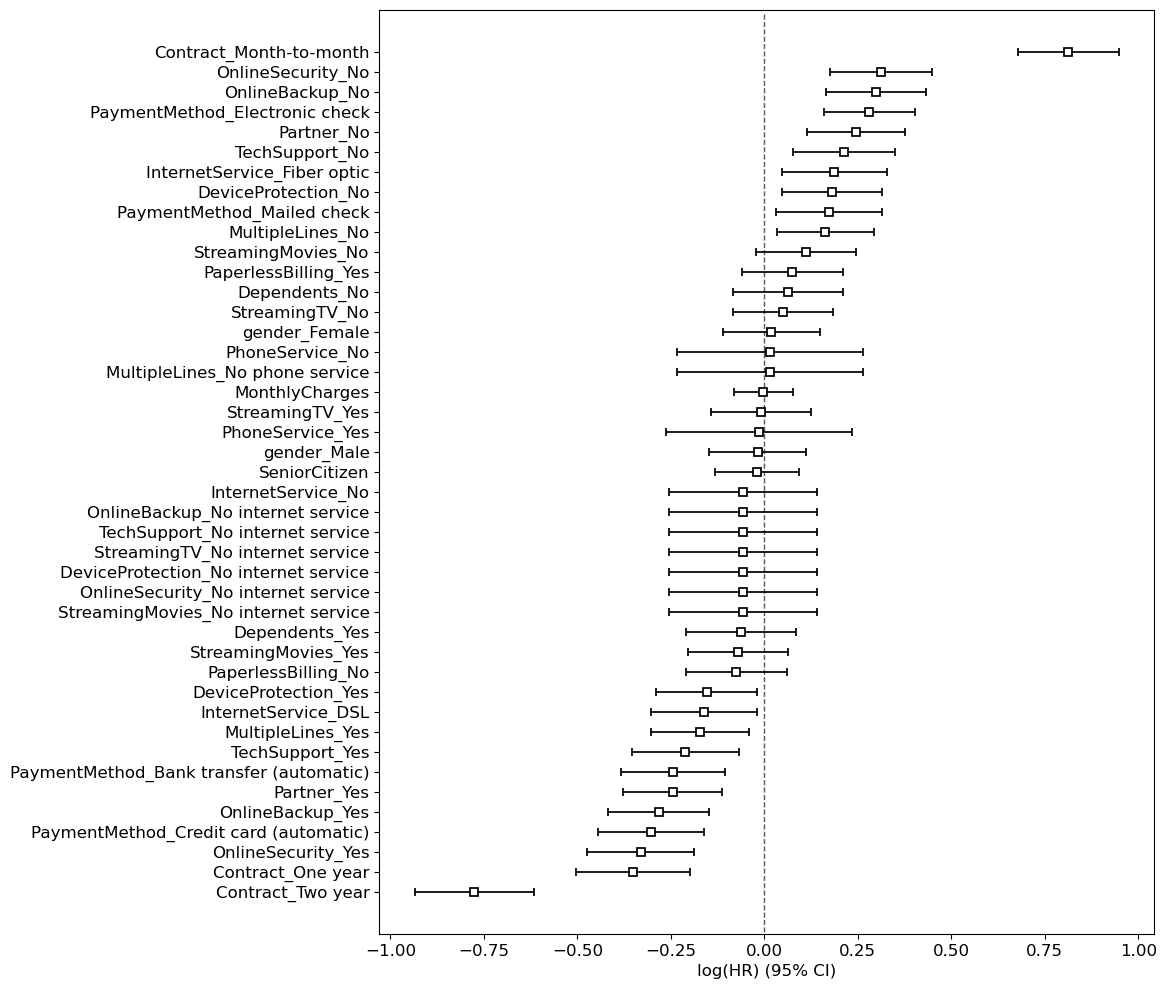

In [80]:
plt.figure(figsize=(10, 12))
cph.plot();

- Ideally we would have more statistical training when using `lifelines` - there is a lot that can go wrong.
  - It comes with various diagnostics as well.

--------

Be mindful of the **The Double-Edged Sword of Statistics**

--------

- Let's look at the survival plots for the people with 
    - two-year contract (Contract_Two year = 1) and 
    - people without two-year contract (Contract_Two year = 0)
- As expected, the former survive longer. 

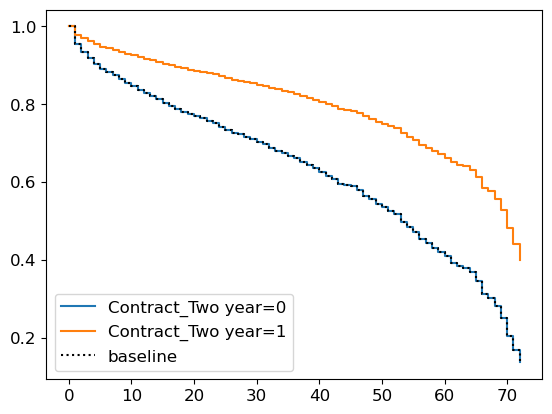

In [81]:
cph.plot_partial_effects_on_outcome("Contract_Two year", [0, 1]);

Check documentation of [plot_partial_effects_on_outcome](https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html)
> Produces a plot comparing the baseline curve of the model versus what happens when a covariate(s) is varied over values in a group. This is useful to compare subjects’ survival as we vary covariate(s), all else being held equal.

> The baseline curve is equal to the predicted curve at all average values (median for ordinal, and mode for categorical) in the original dataset. This same logic is applied to the stratified datasets if strata was used in fitting.

Now let's look at the survival plots for the people with different MonthlyCharges. 

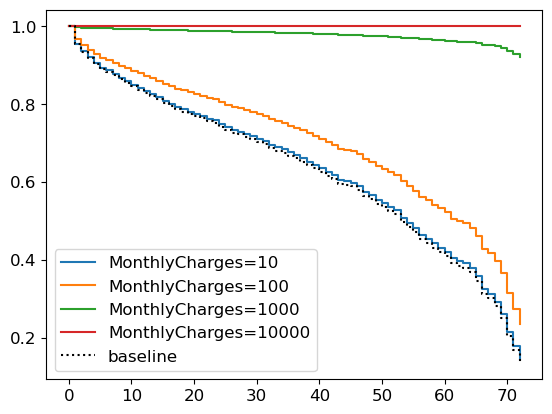

In [82]:
cph.plot_partial_effects_on_outcome("MonthlyCharges", [10, 100, 1000, 10_000]);

- That's the thing with linear models, they can't stop the growth.
- We have a negative coefficient associated with `MonthlyCharges`

In [83]:
cph_params.loc["MonthlyCharges"]

coef   -0.003185
Name: MonthlyCharges, dtype: float64

<br><br><br><br>

## Prediction

- We can use survival analysis to make predictions as well.
- Here is the expected number of months to churn for the first 5 customers in the test set:

Remove the `["tenure", "Churn"]` columns from the test set as we are aiming to predict **survival**

In [84]:
test_df_surv.drop(columns=["tenure", "Churn"]).head()

,SeniorCitizen,MonthlyCharges,PaperlessBilling_No,PaperlessBilling_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,gender_Female,gender_Male,Partner_No,Partner_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No
941,0.0,-1.154900,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1404,0.0,-1.383246,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5515,0.0,-1.514920,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3684,0.0,0.351852,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
7017,0.0,-1.471584,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


How long each non-churned customer is likely to stay according to the model **assuming that they just joined right now** based on their features?  

In [85]:
cph.predict_expectation(test_df_surv).head()  # assumes they just joined right now

941     35.206724
1404    69.023086
5515    68.608565
3684    27.565062
7017    67.890933
dtype: float64

Here, **expectation** is the area under the survival curve (see the survical curves below).

Survival curves for first 5 customers in the test set:

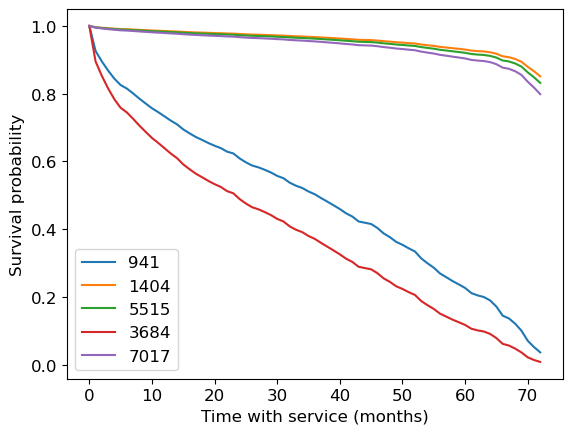

In [86]:
cph.predict_survival_function(test_df_surv[:5]).plot()
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

`predict_survival_function` predicts the survival function for a subject, given their covariates (features). **This assumes that the individual just entered the study** (that is, we do not condition on how long they have already been with our service) 

So these curves are "starting now".

- There's no probability prerequisite for this course, so this is optional material, so:
  - **conditional probabilities** is when a likelihood is conditioned on occurrence of another event (seriously, it means that, haha!)
- "Given that a customer has been here 5 months, what's the outlook?"
  - It will be different than for a new customer. 
  - Thus, we might still want to predict for the non-churned customers in the training set!
  - Not something we really thought about with our traditional supervised learning.

<br><br><br><br><br>
**Finding a good customer to test our experiments on...**

Let's get the customers who have not churned yet.  

In [87]:
train_df_surv_not_churned = train_df_surv[train_df_surv["Churn"] == 0]

We can _condition_ on the **person having been around for 20 months**.

In [88]:
train_df_surv_not_churned[:1]

,Churn,tenure,SeniorCitizen,MonthlyCharges,PaperlessBilling_No,PaperlessBilling_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineBackup_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,gender_Female,gender_Male,Partner_No,Partner_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No
6464,0.0,50.0,1.0,0.185175,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [89]:
cph.predict_survival_function(train_df_surv_not_churned[:1])

,6464
0.0,1.000000
1.0,0.977622
2.0,0.967944
3.0,0.959255
4.0,0.951424
...,...
68.0,0.537438
69.0,0.508767
70.0,0.459245
71.0,0.419682


In [90]:
cph.predict_survival_function(train_df_surv_not_churned[:1], conditional_after=20)

,6464
0.0,1.000000
1.0,0.996788
2.0,0.991966
3.0,0.989443
4.0,0.982570
...,...
68.0,0.429634
69.0,0.429634
70.0,0.429634
71.0,0.429634


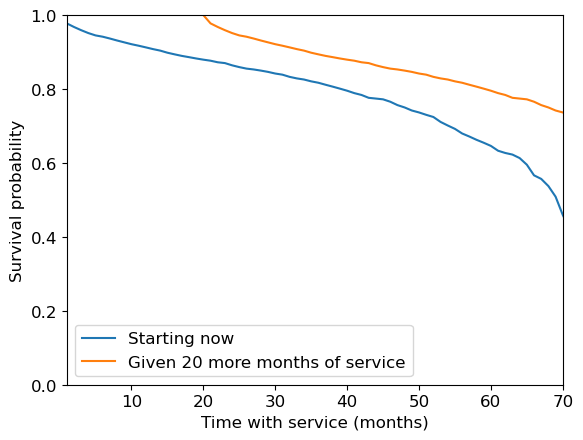

In [91]:
plt.figure()
preds = cph.predict_survival_function(train_df_surv_not_churned[:1])#.plot(ax=plt.gca())
preds_conditional = cph.predict_survival_function(
    train_df_surv_not_churned[:1], conditional_after=20
)

plt.plot(preds)
# To overlay in the same plot, we have to skip the first 20 values in the preds_conditional Series because those values
# are the survival probability for the next 20 years. But, we have conditioned on 20 years, so, we are assuming the user has a survival probability of 100%
# in the next 20 years and we start calculating survival from then.
plt.plot(preds_conditional.index[20:], preds.values[:-20])

plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability")
plt.legend(["Starting now", "Given 20 more months of service"])
plt.ylim([0, 1])
plt.xlim([1, 70]);

- Look at how the survival function (and expected lifetime) is much longer _given_ that the customer has already lasted 20 months.

**How long each non-churned customer is likely to stay** according to the model assuming that they have been here for the tenure time? 
- So, we can set this to their actual tenure so far to get a prediciton of what will happen going forward:

In [92]:
train_df_surv_not_churned[:1]["tenure"]

6464    50.0
Name: tenure, dtype: float64

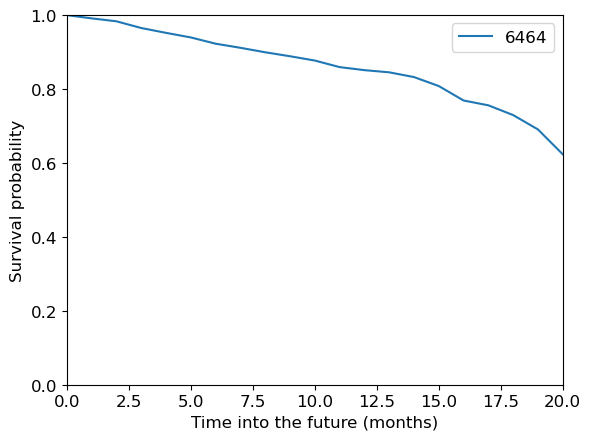

In [93]:
cph.predict_survival_function(
    train_df_surv_not_churned[:1],
    conditional_after=train_df_surv_not_churned[:1]["tenure"], # --> Conditioning on their actual tenure --> ***important***
).plot()
plt.xlabel("Time into the future (months)")
plt.ylabel("Survival probability")
plt.ylim([0, 1])
plt.xlim([0, 20]);

- Another useful application: you could ask what is the [customer lifetime value](https://en.wikipedia.org/wiki/Customer_lifetime_value).
  - Basically, how much money do you expect to make off this customer between now and when they churn?
- With regular supervised learning, tenure was a feature and we could only predict whether or not they had churned by then.

<br><br>

## Evaluate the Model

By default score returns "partial log likelihood":

In [94]:
train_df_surv

,Churn,tenure,SeniorCitizen,MonthlyCharges,PaperlessBilling_No,PaperlessBilling_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineBackup_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,gender_Female,gender_Male,Partner_No,Partner_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No
6464,0.0,50.0,1.0,0.185175,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5707,0.0,2.0,0.0,-0.641538,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3442,0.0,29.0,0.0,1.133562,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3932,1.0,2.0,1.0,0.458524,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
6124,0.0,57.0,0.0,-0.183179,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,0.0,0.0,0.0,-1.503253,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4060,0.0,54.0,0.0,-0.048171,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1346,1.0,14.0,0.0,0.748541,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3454,0.0,29.0,1.0,-0.971556,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [95]:
cph.score(train_df_surv)

-1.8641864337292489

In [96]:
cph.score(test_df_surv)

-1.7277854625841886

We can look at the "concordance index" which is more interpretable and is a generalization of the **AUC** (area under the ROC curve) for survival data, including censoring.

In [97]:
cph.score(train_df_surv, scoring_method="concordance_index")

0.8625887634559019

In [98]:
cph.score(test_df_surv, scoring_method="concordance_index")

0.8546143543902771

----------------
**[Optional]**

From the documentation [here](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-and-calibration-in-survival-regression):

> Another censoring-sensitive measure is the concordance-index, also known as the c-index. This measure evaluates the accuracy of the ranking of predicted time. It is in fact a generalization of AUC, another common loss function, and is interpreted similarly:
> 
> - 0.5 is the expected result from random predictions,
> - 1.0 is perfect concordance and,
> - 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)
> 
> [Here](https://stats.stackexchange.com/a/478305/11867) is an excellent introduction & description of the c-index for new users.


In [99]:
cph.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 43
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
        2206.68 <0.005       inf

In [100]:
cph.check_assumptions(train_df_surv)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 5282 total observations, 3912 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic      p  -log2(p)
Contract_Month-to-month                 km              0.07   0.80      0.33
                                        rank            0.00   0.97      0.04
Contract_One year                       km             14.52 <0.005     12.81
                                        rank           10.11 <0.005      9.41
Contract_Two year                       km              8.86 <0.005      8.42
                                        rank            7.69   0.01      7.49
Dependents_No                           km              0.07   0.79      0.34
                                        rank            0.07   0.79      0.34
Dependents_Yes                          km              0.07   0.79      0.34
                                        rank            0.07   0.79      0.34
DeviceProtection_No                     km              0.07   0.79      0.34
                                        rank            0.08   0.77      0.37
DeviceProtection_No internet service    km              0.25   0.62      0.69
                                        rank            0.26   0.61      0.72
DeviceProtection_Yes                    km              0.70   0.40      1.31
                                        rank            0.76   0.38      1.38
InternetService_DSL                     km              0.32   0.57      0.81
                                        rank            0.28   0.59      0.75
InternetService_Fiber optic             km              1.02   0.31      1.68
                                        rank            0.98   0.32      1.64
InternetService_No                      km              0.25   0.62      0.69
                                        rank            0.26   0.61      0.72
MonthlyCharges                          km              1.65   0.20      2.33
                                        rank            1.72   0.19      2.40
MultipleLines_No                        km              1.57   0.21      2.25
                                        rank            1.87   0.17      2.55
MultipleLines_No phone service          km              0.03   0.86      0.21
                                        rank            0.05   0.83      0.27
MultipleLines_Yes                       km              1.92   0.17      2.59
                                        rank            2.35   0.13      3.00
OnlineBackup_No                         km              0.29   0.59      0.76
                                        rank            0.24   0.63      0.68
OnlineBackup_No internet service        km              0.25   0.62      0.69
                                        rank            0.26   0.61      0.72
OnlineBackup_Yes                        km              1.25   0.26      1.92
                                        rank            1.17   0.28      1.84
OnlineSecurity_No                       km              0.02   0.88      0.19
                                        rank            0.09   0.77      0.38
OnlineSecurity_No internet service      km              0.25   0.62      0.69
                                        rank            0.26   0.61      0.72
OnlineSecurity_Yes                      km              0.56   0.46      1.13
                                        rank            0.85   0.36      1.49
PaperlessBilling_No                     km              0.03   0.86      0.21
                                        rank            0.02   0.90      0.16
PaperlessBilling_Yes                    km              0.03   0.86      0.21
                                        rank            0.02   0.90      0.16
Partner_No                              km             



1. Variable 'Contract_One year' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_One year', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'Contract_Two year' failed the non-proportional test: p-value is 0.0029.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_Two year', ...]`
in the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-f

[]

**[Optional]**

----------------


<br><br><br><br>

## Other approaches / what did we not cover? (5 min)

There are many other approaches to modelling in survival analysis:

- Time-varying proportional hazards.
  - What if some of the features change over time, e.g. plan type, number of lines, etc.
- Approaches based on deep learning, e.g. the [pysurvival](https://square.github.io/pysurvival/) package.
- Random survival forests.
- And more...

### Types of censoring
There are also various types and sub-types of censoring we didn't cover:

- **We learned about "right censoring" today**
- Sub-types within right censoring
  - Did everyone join at the same time?
  - Other reasons the data might be censored at random times, e.g. the person died?
- Left censoring
- Interval censoring

## Summary

- Censoring and and its impact if not handled properly, e.g.,
  - if thrown away people who haven't churned, or
  - assume everyone churned today (at the time of snapshot)
- Predicting tenure vs. churned
- Survival analysis encompasses both of these, and deals with censoring
- And it can make rich and interesting predictions!
- Survival Analysis Models:
  - KM (Kaplan Meier) model -> doesn't look at features
  - CPH (Cox Prop Hazard) model -> like linear regression, does look at the features

## References

Some people working with this same dataset:

- https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a
- https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5 (Cox)
- https://towardsdatascience.com/survival-analysis-in-python-a-model-for-customer-churn-e737c5242822
- https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

lifelines documentation: 
- https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
- https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#introduction-to-survival-analysis